In [1]:
# cellule de imports (aucun param a changer)
%matplotlib notebook

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
# cellule de fonction (aucun param a changer)
def onclick(event):
    """
    Fonction permettant de positionner les interfaces du capillaire manuellement (avec un clic de la souris)
    :param event:
    """
    tx = 'coord: x=%.2f, y=%.2f' % (event.xdata, event.ydata)
    text.set_text(tx)
    coords.append([event.xdata, event.ydata])

def geo_masque(coords):
    """
    Fonction permettant de placer un masque du capillaire sur l'image en fonction des coordonnees
    entrer par le testeur
    :param coords: coordonees du capillaire ([[x_paroi sup][z_paroi_sup]][[x_paroi_inf][z_paroi_inf]])
    :return: centre du capillaire et rayon interieur du capillaire
    """
    # Entrée des coordonnées des parois
    # Image 0 degrés
    # Paroi intérieure supérieure
    x_0_sup = coords[0][0]
    z_0_sup = coords[0][1] 
        # Paroi intérieure inférieure
    x_0_inf = coords[1][0]
    z_0_inf = coords[1][1]
    centre = [(x_0_sup+x_0_inf)/2, (z_0_sup+z_0_inf)/2]
    rayon_int = np.abs((x_0_sup-x_0_inf)/2)
    return centre, rayon_int

def masque(nz, ny, centre, rayon_int, b_scan, ):
    """
    Fonction permettant d'appliquer et afficher le masque elliptique sur l'image
    :param nz: taille de l'image sur l'axe z
    :param ny: taille de l'image sur l'axe y
    :param centre: centre du capillaire
    :param rayon_int: rayon interieur du capillaire
    :param b_scan: b_scan de l'image
    :return: image segementee avec le masque cree manuellement par le testeur
    """
    # vecteur des coordonnées sur l'axe z (nombre de colonne)
    z = np.linspace(0, nz, nz)
    # vecteur des coordonnées sur l'axe y (nombre de ligne)
    y = np.linspace(0, ny, ny)
    # par defaut meshgrid utilise un indexage cartésien
    zv, yv = np.meshgrid(z, y, sparse=False, indexing='xy')
    # creation carte distance du centre
    dist_du_centre = np.sqrt((delta_r *(zv - centre[0]))**2 + (yv - centre[1])**2)
    # masque de l'intérieur du tube capillaire
    masque_capillaire_int = dist_du_centre <= rayon_int
    # initialisation de la carte d'indice de refraction indexage 'ij'
    masque = np.zeros([ny, nz])
    masque[masque_capillaire_int] = 1
    # application du masque
    b_scan_seg = b_scan * masque 
    # affichage du masque
    plt.imshow(b_scan_seg)
    plt.show()
    return b_scan_seg


def snr(b_scan_seg, b_scan_seg_ref):
    """
    Calcul du SNR entre l'image et l'image de reference en fonction de la puissance du signal 
    en fonction de la formule de « digital image processing » (Gonzalez, 2018)
    :param b_scan_seg: image segementee avec le masque cree manuellement par le testeur
    :param b_scan_seg_ref: image de reference segementee avec le masque cree manuellement par le testeur
    """
    # Calcul de la puissance du signal
    p_signal = sum(sum(b_scan_seg**2))
    print("La puisssance du signal est :  {}".format(p_signal))
    p_bruit = sum(sum((b_scan_seg - b_scan_seg_ref)**2))
    print("La puisssance du bruit est :  {}".format(p_bruit))
    snr = 10 * np.log(p_signal/p_bruit)
    print("Le rapport signal sur bruit est :  {}".format(snr))

In [3]:
# cellule de variable (changer le path vers les images)
# obtenir le path vers l'image dans l'eau
path_image = "data/data_test_oct_billes_0_degree.nii"
# obtenir le path vers l'image de ref dans l'eau
path_image_ref = "data/data_test_oct_1degree.nii"

# rentrer la resolution de l'image
delta_x = 3.91 # en um
delta_z = 6.53 # en um
# sert a corriger la difference de resolution entre x et y en creant un masque ovale pour la segmentation
delta_r = delta_z / delta_x

Le format de l'image est (x:512, y:512, z:576)


<IPython.core.display.Javascript object>


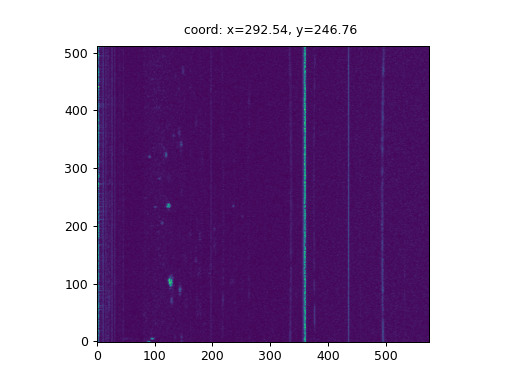

In [4]:
# cellule (si l'image est un C_scan choisir une slice (x_tube) pour segmenter un B_scan)
# get image (z: axe de propagation laser, y: axe de rotation capillaire, x: axe perpendiculaire
# a la rotation capillaire)
image = nib.load(path_image)
# extraire le format de l'image
nx, ny, nz = image.shape
print("Le format de l'image est (x:{}, y:{}, z:{})".format(nx, ny, nz))
# extraire un b_scan avec plan 'zy'
data = image.get_fdata()
# selectionne la slice d'interet
x_tube = 310
b_scan = data[:, x_tube, :]

global coords
coords = []
    
fig = plt.figure("cliquer sur les parois sup puis inf et fermer")
ax = fig.add_subplot(111)
ax.imshow(b_scan, origin="lower")
text = ax.text(150,550, "", va="top", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

<IPython.core.display.Javascript object>


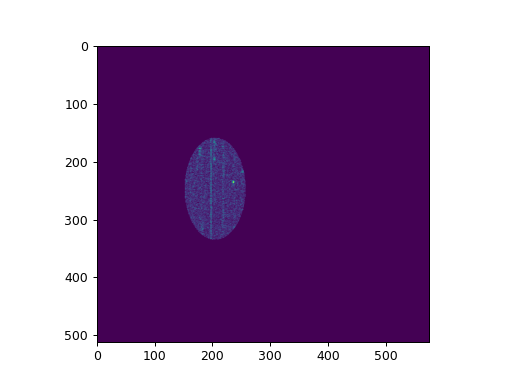

In [5]:
# application du masque sur le b_scan selectionne
centre, rayon_int = geo_masque(coords)
b_scan_seg = masque(nz, ny, centre, rayon_int, b_scan)

In [ ]:
# cellule (si l'image est un C_scan choisir une slice (x_tube) pour segmenter un B_scan)
# get image (z: axe de propagation laser, y: axe de rotation capillaire, x: axe perpendiculaire
# a la rotation capillaire)
image = nib.load(path_image_ref)
# extraire le format de l'image
nx, ny, nz = image.shape
print("Le format de l'image est (x:{}, y:{}, z:{})".format(nx, ny, nz))
# extraire un b_scan avec plan 'zy'
data = image.get_fdata()
x_tube = 310
b_scan = data[:, x_tube, :]

global coords
coords = []
    
fig = plt.figure("cliquer sur les parois sup puis inf et fermer")
ax = fig.add_subplot(111)
ax.imshow(b_scan, origin="lower")
text = ax.text(150,550, "", va="top", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:
centre, rayon_int = geo_masque(coords)
b_scan_seg_ref = masque(nz, ny, centre, rayon_int, b_scan)

In [ ]:
# Calcul du SNR
snr(b_scan_seg, b_scan_seg_ref)